In [2]:
import pickle
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.linear_model import RidgeCV
sns.set_style("darkgrid")
%pylab inline

C:\Users\Kandice\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


C:\Users\Kandice\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
def make_pickles(objs):
    for filename, obj in objs:
        with open(filename, "wb") as picklefile:
            pickle.dump(obj, picklefile)

def get_pickles(pkls):
    if len(pkls) == 1:
        with open(pkls[0], "rb") as picklefile:
            objs = pickle.load(picklefile)
    else:
        objs = []
        for filename in pkls:
            with open(filename, "rb") as picklefile:
                objs.append(pickle.load(picklefile))
    return objs            

---

In [5]:
df_merge = get_pickles(['df_merge.pkl'])

In [6]:
df_merge.columns

Index(['title', 'year', 'runtime', 'opening_adj', 'Opening Theaters',
       'Production Budget', 'distr_20', 'genre_grp', 'rating_grp', 'Franchise',
       'Season'],
      dtype='object')

---

In [7]:
df = df_merge[['opening_adj','Production Budget','Opening Theaters','runtime','distr_20',\
                   'genre_grp','rating_grp','Franchise','Season']]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4397 entries, 0 to 4396
Data columns (total 9 columns):
opening_adj          4397 non-null float64
Production Budget    4397 non-null float64
Opening Theaters     4397 non-null float64
runtime              4397 non-null float64
distr_20             4397 non-null float64
genre_grp            4397 non-null object
rating_grp           4074 non-null object
Franchise            4397 non-null int64
Season               4397 non-null object
dtypes: float64(5), int64(1), object(3)
memory usage: 343.5+ KB


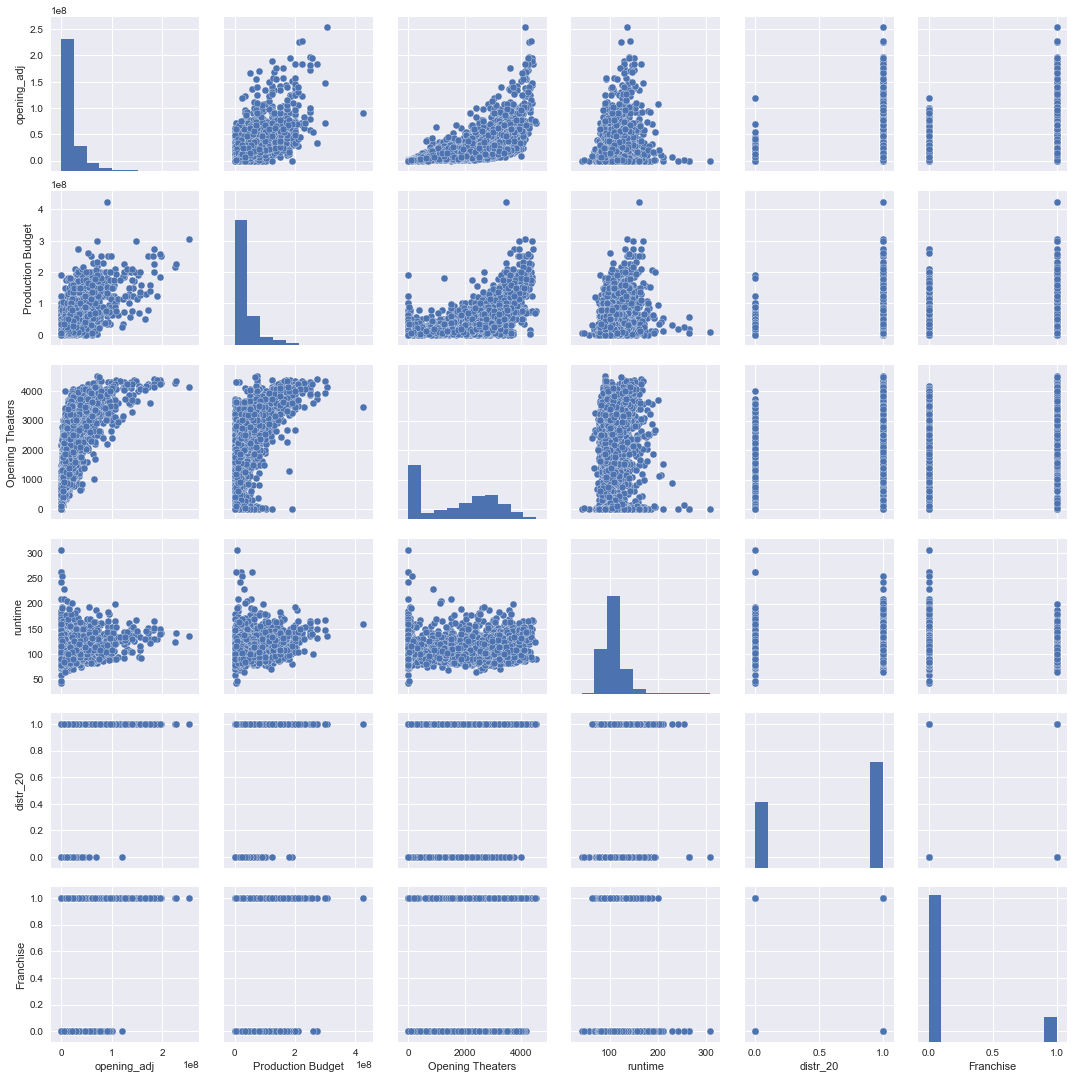

In [9]:
sns.pairplot(df);

---

In [10]:
df.genre_grp.unique()

array(['Other', 'Thriller', 'Drama', 'Comedy', 'Action', 'Horror', 'Sci-Fi'], dtype=object)

In [11]:
genre=patsy.dmatrix('genre_grp',data=df,return_type='dataframe')
genre.head()

,Intercept,genre_grp[T.Comedy],genre_grp[T.Drama],genre_grp[T.Horror],genre_grp[T.Other],genre_grp[T.Sci-Fi],genre_grp[T.Thriller]
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [12]:
df.rating_grp.unique()

array([nan, 'PG-13', 'G', 'R', 'PG', 'NC-17'], dtype=object)

In [13]:
rating=patsy.dmatrix('rating_grp',data=df,return_type='dataframe')
rating.head()

,Intercept,rating_grp[T.NC-17],rating_grp[T.PG],rating_grp[T.PG-13],rating_grp[T.R]
1,1.0,0.0,0.0,1.0,0.0
6,1.0,0.0,0.0,1.0,0.0
7,1.0,0.0,0.0,1.0,0.0
8,1.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,1.0


In [14]:
df.Season.unique()

array(['Winter', 'Spring', 'Summer', 'Fall'], dtype=object)

In [15]:
season=patsy.dmatrix('Season',data=df,return_type='dataframe')
season.head()

,Intercept,Season[T.Spring],Season[T.Summer],Season[T.Winter]
0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0
2,1.0,1.0,0.0,0.0
3,1.0,1.0,0.0,0.0
4,1.0,1.0,0.0,0.0


In [16]:
df_join = df.join(genre)
df_join = df_join.join(rating.drop(['Intercept'],axis=1))
df_join = df_join.join(season.drop(['Intercept'],axis=1))

In [17]:
df_join.columns

Index(['opening_adj', 'Production Budget', 'Opening Theaters', 'runtime',
       'distr_20', 'genre_grp', 'rating_grp', 'Franchise', 'Season',
       'Intercept', 'genre_grp[T.Comedy]', 'genre_grp[T.Drama]',
       'genre_grp[T.Horror]', 'genre_grp[T.Other]', 'genre_grp[T.Sci-Fi]',
       'genre_grp[T.Thriller]', 'rating_grp[T.NC-17]', 'rating_grp[T.PG]',
       'rating_grp[T.PG-13]', 'rating_grp[T.R]', 'Season[T.Spring]',
       'Season[T.Summer]', 'Season[T.Winter]'],
      dtype='object')

In [18]:
df_join.drop(['genre_grp','rating_grp','Season'],axis=1, inplace=True)

In [19]:
df_join.columns = ['opening', 'budget', 'theaters', 'runtime',
       'distr_20', 'franchise', 'Intercept', 'Comedy', 'Drama',
       'Horror', 'Other', 'Sci_Fi', 'Thriller', 'NC_17', 'PG',
       'PG_13', 'R', 'Spring','Summer', 'Winter']

---

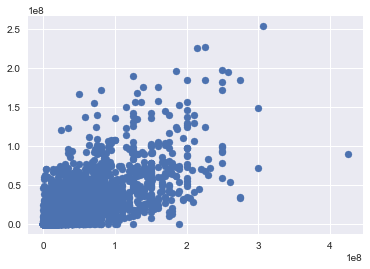

In [20]:
plt.scatter(df_join.budget,df_join.opening)

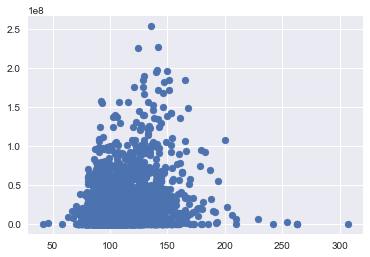

In [21]:
plt.scatter(df_join.runtime, df_join.opening)

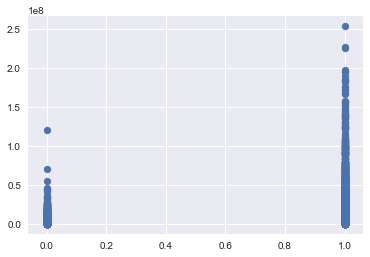

In [22]:
plt.scatter(df_join.distr_20, df_join.opening)

In [24]:
df_join.corr().opening.sort_values()

R           -0.269121
Drama       -0.177272
Spring      -0.073305
Comedy      -0.058566
NC_17       -0.026536
Thriller    -0.025890
Other       -0.012558
Horror       0.013873
Winter       0.031396
PG           0.077506
Summer       0.089881
Sci_Fi       0.126987
PG_13        0.208601
runtime      0.245156
distr_20     0.465077
franchise    0.537762
theaters     0.671584
budget       0.697158
opening      1.000000
Intercept         NaN
Name: opening, dtype: float64

In [25]:
df_join.columns

Index(['opening', 'budget', 'theaters', 'runtime', 'distr_20', 'franchise',
       'Intercept', 'Comedy', 'Drama', 'Horror', 'Other', 'Sci_Fi', 'Thriller',
       'NC_17', 'PG', 'PG_13', 'R', 'Spring', 'Summer', 'Winter'],
      dtype='object')

In [26]:
lm1 = smf.ols('opening ~ budget + theaters + runtime + distr_20 + franchise', data=df_join)
fit1 = lm1.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                opening   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     1611.
Date:                Mon, 09 Oct 2017   Prob (F-statistic):               0.00
Time:                        23:33:28   Log-Likelihood:                -78853.
No. Observations:                4397   AIC:                         1.577e+05
Df Residuals:                    4391   BIC:                         1.578e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.303e+07   1.35e+06     -9.633      0.000   -1.57e+07   -1.04e+07
budget         0.2202      0.007     30.085      0.000       0.206       0.235
theaters    5668.8714    280.737     20.193      0.000    5118.485    6219.258
runtime     9.326e+04   1.26e+04      7.407      0.000    6.86e+04    1.18e+05
distr_20    4.936e+05   6.44e+05      0.767      0.443   -7.68e+05    1.76e+06
franchise   2.098e+07   6.95e+05     30.186      0.000    1.96e+07    2.23e+07
==============================================================================
Omnibus:                     2410.660   Durbin-Watson:                   1.748
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            41963.302
Skew:                           2.231   Prob(JB):                         0.00
Kurtosis:                      17.461   Cond. No.                     3.34e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.34e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [67]:
lm1 = smf.ols('opening ~ budget + theaters + runtime + distr_20 + franchise + Comedy + Drama + Horror + Other + Sci_Fi \
                + Thriller', data=df_join)
fit1 = lm1.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                opening   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     733.3
Date:                Fri, 06 Oct 2017   Prob (F-statistic):               0.00
Time:                        05:28:40   Log-Likelihood:                -78850.
No. Observations:                4397   AIC:                         1.577e+05
Df Residuals:                    4385   BIC:                         1.578e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.251e+07   1.58e+06     -7.914      0.000   -1.56e+07   -9.41e+06
budget         0.2187      0.008     28.518      0.000       0.204       0.234
theaters    5651.5345    286.465     19.729      0.000    5089.918    6213.151
runtime     9.875e+04   1.31e+04      7.561      0.000    7.31e+04    1.24e+05
distr_20    4.581e+05   6.47e+05      0.708      0.479    -8.1e+05    1.73e+06
franchise   2.081e+07    7.1e+05     29.289      0.000    1.94e+07    2.22e+07
Comedy     -6.269e+05   8.57e+05     -0.731      0.465   -2.31e+06    1.05e+06
Drama      -1.606e+06   9.46e+05     -1.697      0.090   -3.46e+06    2.49e+05
Horror     -1.048e+06   1.02e+06     -1.029      0.303   -3.05e+06    9.49e+05
Other       -6.89e+05   8.49e+05     -0.811      0.417   -2.35e+06    9.76e+05
Sci_Fi     -1.777e+06   1.25e+06     -1.424      0.154   -4.22e+06    6.69e+05
Thriller   -2.233e+06   1.03e+06     -2.170      0.030   -4.25e+06   -2.16e+05
==============================================================================
Omnibus:                     2401.738   Durbin-Watson:                   1.748
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            41679.453
Skew:                           2.221   Prob(JB):                         0.00
Kurtosis:                      17.414   Cond. No.                     5.20e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.2e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [71]:
lm1 = smf.ols('opening ~ budget + theaters + runtime + distr_20 + franchise + NC_17 + PG + PG_13 + R', data=df_join)
fit1 = lm1.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                opening   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     792.7
Date:                Fri, 06 Oct 2017   Prob (F-statistic):               0.00
Time:                        05:31:36   Log-Likelihood:                -73193.
No. Observations:                4074   AIC:                         1.464e+05
Df Residuals:                    4064   BIC:                         1.465e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.509e+07   2.17e+06     -6.948      0.000   -1.94e+07   -1.08e+07
budget         0.2158      0.008     27.625      0.000       0.200       0.231
theaters    5665.5275    298.392     18.987      0.000    5080.516    6250.539
runtime     1.158e+05   1.51e+04      7.689      0.000    8.62e+04    1.45e+05
distr_20    5.465e+05   6.79e+05      0.804      0.421   -7.85e+05    1.88e+06
franchise   2.115e+07   7.21e+05     29.325      0.000    1.97e+07    2.26e+07
NC_17       1.622e+06   6.08e+06      0.267      0.790   -1.03e+07    1.35e+07
PG          -1.21e+06   1.79e+06     -0.676      0.499   -4.72e+06     2.3e+06
PG_13       7.858e+05   1.75e+06      0.450      0.653   -2.64e+06    4.21e+06
R          -8.979e+05   1.76e+06     -0.511      0.609   -4.34e+06    2.54e+06
==============================================================================
Omnibus:                     2123.942   Durbin-Watson:                   1.748
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32226.347
Skew:                           2.126   Prob(JB):                         0.00
Kurtosis:                      16.106   Cond. No.                     1.47e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [72]:
lm1 = smf.ols('opening ~ budget + theaters + runtime + distr_20 + franchise + Spring + Summer + Winter', data=df_join)
fit1 = lm1.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                opening   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     1017.
Date:                Fri, 06 Oct 2017   Prob (F-statistic):               0.00
Time:                        05:32:36   Log-Likelihood:                -78838.
No. Observations:                4397   AIC:                         1.577e+05
Df Residuals:                    4388   BIC:                         1.578e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.544e+07   1.44e+06    -10.720      0.000   -1.83e+07   -1.26e+07
budget         0.2174      0.007     29.697      0.000       0.203       0.232
theaters    5687.0129    279.875     20.320      0.000    5138.316    6235.710
runtime     9.804e+04   1.26e+04      7.793      0.000    7.34e+04    1.23e+05
distr_20     5.91e+05   6.42e+05      0.921      0.357   -6.68e+05    1.85e+06
franchise   2.077e+07   6.94e+05     29.940      0.000    1.94e+07    2.21e+07
Spring      1.302e+06   6.51e+05      1.998      0.046    2.47e+04    2.58e+06
Summer       3.18e+06   6.51e+05      4.882      0.000     1.9e+06    4.46e+06
Winter      2.949e+06   6.65e+05      4.432      0.000    1.64e+06    4.25e+06
==============================================================================
Omnibus:                     2427.468   Durbin-Watson:                   1.752
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43039.482
Skew:                           2.247   Prob(JB):                         0.00
Kurtosis:                      17.654   Cond. No.                     3.71e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.71e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [74]:
# Define the model
lm1 = smf.ols('opening ~ budget + theaters + runtime + distr_20 + franchise + Comedy + Drama +\
                Horror + Other + Sci_Fi + Thriller + NC_17 + PG + PG_13 + R + Spring + Summer + Winter', data=df_join)
# Fit the model
fit1 = lm1.fit()
# Print summary statistics of the model's performance
fit1.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                opening   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     401.5
Date:                Fri, 06 Oct 2017   Prob (F-statistic):               0.00
Time:                        05:33:58   Log-Likelihood:                -73174.
No. Observations:                4074   AIC:                         1.464e+05
Df Residuals:                    4055   BIC:                         1.465e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.796e+07   2.45e+06     -7.320      0.000   -2.28e+07   -1.31e+07
budget         0.2120      0.008     26.085      0.000       0.196       0.228
theaters    5673.3736    305.411     18.576      0.000    5074.600    6272.148
runtime     1.285e+05   1.58e+04      8.146      0.000    9.76e+04    1.59e+05
distr_20     6.26e+05   6.82e+05      0.918      0.359   -7.11e+05    1.96e+06
franchise   2.077e+07   7.37e+05     28.171      0.000    1.93e+07    2.22e+07
Comedy     -2.646e+05      9e+05     -0.294      0.769   -2.03e+06     1.5e+06
Drama      -1.293e+06   1.02e+06     -1.272      0.203   -3.29e+06       7e+05
Horror     -5.165e+05   1.07e+06     -0.482      0.630   -2.62e+06    1.58e+06
Other      -1.393e+05   9.56e+05     -0.146      0.884   -2.01e+06    1.74e+06
Sci_Fi     -1.892e+06    1.3e+06     -1.451      0.147   -4.45e+06    6.64e+05
Thriller   -1.957e+06   1.08e+06     -1.813      0.070   -4.07e+06    1.59e+05
NC_17       2.509e+06   6.07e+06      0.413      0.679   -9.39e+06    1.44e+07
PG         -1.241e+06    1.8e+06     -0.691      0.490   -4.76e+06    2.28e+06
PG_13       9.027e+05    1.8e+06      0.500      0.617   -2.64e+06    4.44e+06
R           -7.05e+05   1.82e+06     -0.387      0.699   -4.27e+06    2.86e+06
Spring      1.515e+06   7.02e+05      2.158      0.031    1.39e+05    2.89e+06
Summer      3.481e+06   7.03e+05      4.948      0.000     2.1e+06    4.86e+06
Winter      3.209e+06   7.15e+05      4.489      0.000    1.81e+06    4.61e+06
==============================================================================
Omnibus:                     2133.514   Durbin-Watson:                   1.750
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33006.304
Skew:                           2.132   Prob(JB):                         0.00
Kurtosis:                      16.276   Cond. No.                     1.48e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [82]:
lm1 = smf.ols('opening ~ budget + theaters + runtime + franchise + Spring + Summer + Winter', data=df_join)
fit1 = lm1.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                opening   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     1163.
Date:                Fri, 06 Oct 2017   Prob (F-statistic):               0.00
Time:                        06:50:27   Log-Likelihood:                -78838.
No. Observations:                4397   AIC:                         1.577e+05
Df Residuals:                    4389   BIC:                         1.577e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.542e+07   1.44e+06    -10.707      0.000   -1.82e+07   -1.26e+07
budget         0.2171      0.007     29.683      0.000       0.203       0.231
theaters    5840.3762    224.893     25.970      0.000    5399.472    6281.280
runtime     9.903e+04   1.25e+04      7.901      0.000    7.45e+04    1.24e+05
franchise   2.075e+07   6.93e+05     29.927      0.000    1.94e+07    2.21e+07
Spring      1.286e+06   6.51e+05      1.975      0.048    9720.421    2.56e+06
Summer      3.168e+06   6.51e+05      4.865      0.000    1.89e+06    4.44e+06
Winter      2.926e+06   6.65e+05      4.401      0.000    1.62e+06    4.23e+06
==============================================================================
Omnibus:                     2418.744   Durbin-Watson:                   1.753
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            42621.293
Skew:                           2.237   Prob(JB):                         0.00
Kurtosis:                      17.581   Cond. No.                     3.71e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.71e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [84]:
lm2 = smf.ols('opening ~ budget + theaters + runtime + franchise + Summer + Winter', data=df_join)
fit2 = lm2.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                opening   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     1355.
Date:                Fri, 06 Oct 2017   Prob (F-statistic):               0.00
Time:                        06:51:43   Log-Likelihood:                -78840.
No. Observations:                4397   AIC:                         1.577e+05
Df Residuals:                    4390   BIC:                         1.577e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.463e+07   1.38e+06    -10.572      0.000   -1.73e+07   -1.19e+07
budget         0.2170      0.007     29.652      0.000       0.203       0.231
theaters    5827.5131    224.873     25.915      0.000    5386.648    6268.378
runtime     9.857e+04   1.25e+04      7.864      0.000     7.4e+04    1.23e+05
franchise   2.079e+07   6.93e+05     29.991      0.000    1.94e+07    2.22e+07
Summer      2.447e+06    5.4e+05      4.535      0.000    1.39e+06    3.51e+06
Winter      2.204e+06   5.56e+05      3.967      0.000    1.11e+06    3.29e+06
==============================================================================
Omnibus:                     2418.016   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            42604.429
Skew:                           2.237   Prob(JB):                         0.00
Kurtosis:                      17.579   Cond. No.                     3.45e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.45e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
# Create an empty model
lr = LinearRegression()
# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X2 + X3 + X4 + X5 + X6 model
X = df_join[['budget', 'theaters', 'runtime', 'franchise', 'Summer', 'Winter']]
# Choose the response variable(s)
y = df_join['opening']
# Fit the model to the full dataset
lr.fit(X, y)
# Print out the R^2 for the model against the full dataset
lr.score(X,y)

# print out intercept
print(lr.intercept_)
# print out other coefficients
print(lr.coef_)

-14632477.5513
[  2.16955744e-01   5.82751309e+03   9.85743956e+04   2.07909998e+07
   2.44747462e+06   2.20431009e+06]


In [28]:
est = make_pipeline(LinearRegression())
y = df_join['opening']
X = df_join[['budget', 'theaters', 'runtime', 'franchise', 'Summer', 'Winter']]

# INSTRUCTOR NOTE: Run this multiple times to show the variation
# Split the data into training and test sets


In [29]:
for n in range(10):    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    # Fit the model against the training data
    est.fit(X_train, y_train)
    # Evaluate the model against the testing data
    print(f"test r2: {est.score(X_test,y_test):.2}, "
         f"train r2: {est.score(X_train, y_train):.2}")

test r2: 0.64, train r2: 0.65
test r2: 0.63, train r2: 0.66
test r2: 0.67, train r2: 0.64
test r2: 0.67, train r2: 0.64
test r2: 0.64, train r2: 0.65
test r2: 0.66, train r2: 0.65
test r2: 0.63, train r2: 0.66
test r2: 0.64, train r2: 0.65
test r2: 0.64, train r2: 0.65
test r2: 0.67, train r2: 0.64


---

In [98]:
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                opening   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     1355.
Date:                Fri, 06 Oct 2017   Prob (F-statistic):               0.00
Time:                        07:14:11   Log-Likelihood:                -78840.
No. Observations:                4397   AIC:                         1.577e+05
Df Residuals:                    4390   BIC:                         1.577e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.463e+07   1.38e+06    -10.572      0.000   -1.73e+07   -1.19e+07
budget         0.2170      0.007     29.652      0.000       0.203       0.231
theaters    5827.5131    224.873     25.915      0.000    5386.648    6268.378
runtime     9.857e+04   1.25e+04      7.864      0.000     7.4e+04    1.23e+05
franchise   2.079e+07   6.93e+05     29.991      0.000    1.94e+07    2.22e+07
Summer      2.447e+06    5.4e+05      4.535      0.000    1.39e+06    3.51e+06
Winter      2.204e+06   5.56e+05      3.967      0.000    1.11e+06    3.29e+06
==============================================================================
Omnibus:                     2418.016   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            42604.429
Skew:                           2.237   Prob(JB):                         0.00
Kurtosis:                      17.579   Cond. No.                     3.45e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.45e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

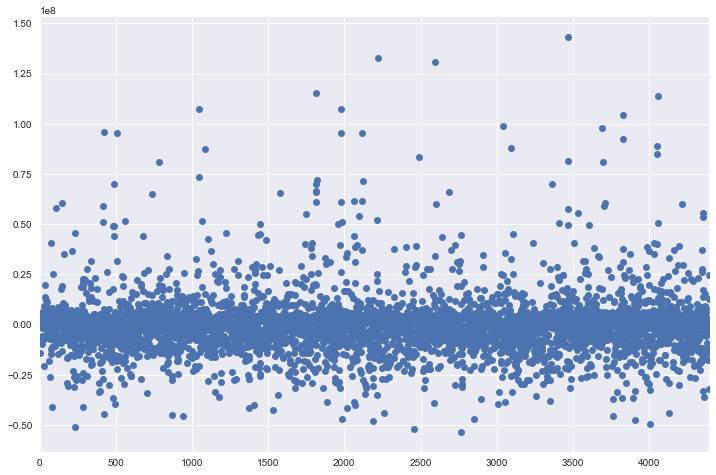

In [101]:
# Use statsmodels to plot the residuals
fit2.resid.plot(style='o', figsize=(12,8))

---